# Notebook

## Setting up

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import TextClassificationPipeline
from transformers import pipeline

from peft import get_peft_model, LoraConfig, TaskType

# suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 1

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(4168, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [108]:
dataset = Dataset.from_pandas(df)

# 80% train, 20% test+validation
train_test = dataset.train_test_split(test_size=0.2)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

print(train_valid_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3334
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 417
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 417
    })
})


## Fine-tuning a pre-trained Hugging Face model

We need to load:
- the pre-trained model itself
- the tokenizer associated with the model (used to preprocess the data)

In [109]:
model_name = "distilbert-base-uncased" # bert-base-uncased

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

We can try to use LoRA to perform the fine-tuning of the model.

In [111]:
# Set up LoRA configuration for distilbert-base-uncased model
# config = LoraConfig(
#     r=32,  # Rank of the low-rank matrices
#     lora_alpha=32,
#     target_modules = ['q_lin', 'k_lin', 'v_lin', 'out_lin', 'q_lin_bias', 'k_lin_bias', 'v_lin_bias', 'out_lin_bias'],
#     task_type=TaskType.SEQ_CLS,  # Task type for sequence classification
#     lora_dropout=0.1
# )

# model = get_peft_model(model, config)

### Pre-processing the data with the tokenizer

In [112]:
def preprocess_function(sample):
    return tokenizer(sample["text"], padding=True, truncation=True, return_tensors="pt")

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3334
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 417
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 417
    })
})


The preprocessing transforms the data into a format that the model can understand. The model then processes the data to make predictions. This is known as **encoding**. Encoding is done in a two-step process: tokenization, followed by conversion to input IDs.

In [113]:
# print(tokenized_dataset['train'][321])
# tokens = tokenizer.tokenize(tokenized_dataset['train'][321]['text'])
# print(tokens)
# ids = tokenizer.convert_tokens_to_ids(tokens)
# print(ids)

### Model training (Fine-tuning)

In [114]:
def predict(text):
    global model, tokenizer
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(predictions)
    predicted_class = torch.argmax(predictions)
    name = [i for i, j in label_map.items() if j == predicted_class.item()][0]
    print(f"Predicted class: {name}")
    
# predict("I'm so sad")

In [115]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [116]:
trainer.evaluate()

  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.8380184173583984,
 'eval_accuracy': 0.03597122302158273,
 'eval_runtime': 17.6387,
 'eval_samples_per_second': 23.641,
 'eval_steps_per_second': 1.531}

In [117]:
start = time.time()
trainer.train()
end = time.time()
print(f"Training time: {(end - start)/60} minutes")

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.3948520421981812, 'eval_accuracy': 0.5179856115107914, 'eval_runtime': 16.666, 'eval_samples_per_second': 25.021, 'eval_steps_per_second': 1.62, 'epoch': 1.0}


  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.2174015045166016, 'eval_accuracy': 0.539568345323741, 'eval_runtime': 19.2605, 'eval_samples_per_second': 21.651, 'eval_steps_per_second': 1.402, 'epoch': 2.0}
{'loss': 1.3785, 'grad_norm': 1.835157871246338, 'learning_rate': 4.051036682615631e-06, 'epoch': 2.39}


  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.1871600151062012, 'eval_accuracy': 0.5443645083932853, 'eval_runtime': 17.8705, 'eval_samples_per_second': 23.334, 'eval_steps_per_second': 1.511, 'epoch': 3.0}
{'train_runtime': 1193.8517, 'train_samples_per_second': 8.378, 'train_steps_per_second': 0.525, 'train_loss': 1.3394844992118968, 'epoch': 3.0}
Training time: 19.903788689772288 minutes


In [118]:
trainer.evaluate()

  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.1871600151062012,
 'eval_accuracy': 0.5443645083932853,
 'eval_runtime': 21.4464,
 'eval_samples_per_second': 19.444,
 'eval_steps_per_second': 1.259,
 'epoch': 3.0}

In [119]:
trainer.predict(test_dataset=tokenized_dataset["test"])

  0%|          | 0/27 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 1.5042312 , -0.46942645, -0.87758887,  0.5508262 ,  0.5680098 ,
        -1.1253242 ],
       [ 1.4485741 , -0.29451597, -0.85153055,  0.4657004 ,  0.6021304 ,
        -0.9874634 ],
       [ 0.3573888 ,  1.0839989 , -0.24508281, -0.14755794,  0.02931421,
        -1.0039793 ],
       ...,
       [ 1.8506008 , -0.96911573, -1.0171157 ,  1.130361  ,  0.3946579 ,
        -1.1260167 ],
       [ 1.3880838 , -0.45947453, -0.799038  ,  1.0078987 ,  0.12592486,
        -1.2535125 ],
       [ 0.07129819,  1.7157575 ,  0.11083698, -0.260745  , -0.39416343,
        -0.91190803]], dtype=float32), label_ids=array([4, 0, 4, 1, 1, 3, 0, 1, 3, 3, 0, 0, 0, 0, 1, 3, 0, 1, 1, 3, 3, 1,
       1, 1, 4, 3, 0, 1, 3, 0, 4, 4, 1, 1, 3, 2, 2, 0, 2, 0, 0, 1, 0, 4,
       1, 1, 3, 0, 3, 2, 0, 0, 0, 4, 1, 1, 0, 5, 4, 0, 3, 4, 2, 0, 2, 1,
       4, 0, 2, 1, 0, 3, 0, 0, 3, 0, 3, 1, 1, 0, 4, 1, 1, 2, 5, 0, 0, 1,
       4, 1, 4, 1, 1, 3, 0, 1, 1, 2, 1, 5, 2, 1, 1, 0, 1, 2, 0, 0, 0, 

### Save & Load Model

In [120]:
trainer.save_model()

tokenizer2 = AutoTokenizer.from_pretrained("./results")
model2 = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=6)

pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2) #, return_all_scores=True)

# pipe("I love this place!")
# pipe("Paris was very disappointing")

Some weights of the model checkpoint at ./results were not used when initializing DistilBertForSequenceClassification: ['base_model.model.classifier.modules_to_save.default.bias', 'base_model.model.classifier.modules_to_save.default.weight', 'base_model.model.classifier.original_module.bias', 'base_model.model.classifier.original_module.weight', 'base_model.model.distilbert.embeddings.LayerNorm.bias', 'base_model.model.distilbert.embeddings.LayerNorm.weight', 'base_model.model.distilbert.embeddings.position_embeddings.weight', 'base_model.model.distilbert.embeddings.word_embeddings.weight', 'base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.bias', 'base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.weight', 'base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight', 'base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight', 'base_model.model.distilbert.transformer.layer.0.attenti

### Evaluate Model Results

In [121]:
def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()

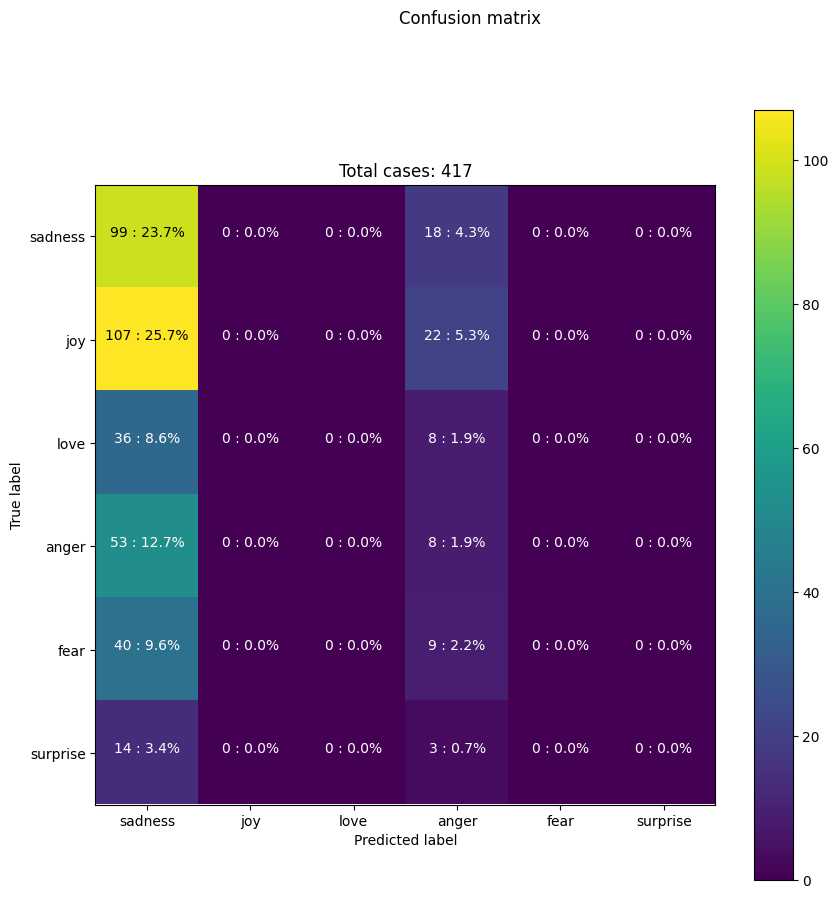

Accuracy:  0.2565947242206235
Precision:  0.06688578010000562
Recall:  0.16288356452290878
F1:  0.09148728526909981


/home/sparks/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [122]:
y_pred= []
for p in tokenized_dataset['test']['text']:
    ti = tokenizer2(p, return_tensors="pt")
    out = model2(**ti)
    pred = torch.argmax(out.logits)
    y_pred.append(pred)
    
y_test = tokenized_dataset['test']['label']

show_cm(confusion_matrix(y_test, y_pred), label_map.keys())
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1: ', f1_score(y_test, y_pred, average='macro'))